In [50]:
import cv2
import numpy as np
from typing import Optional, Tuple, Union

def detect_yellow(
    frame_rgb: np.ndarray,
    lower_hsv: Tuple[int, int, int] = (28, 255, 255),
    upper_hsv: Tuple[int, int, int] = (15, 134, 109),
    *,
    min_area_frac: float = 0.002,
    k_open: int = 5,
    k_close: int = 11,
) -> Tuple[np.ndarray, Optional[Tuple[float, float]]]:
    if frame_rgb is None or frame_rgb.ndim != 3 or frame_rgb.shape[2] != 3:
        raise ValueError("Expected HxWx3 RGB image (uint8).")
    if frame_rgb.dtype != np.uint8:
        frame_rgb = frame_rgb.astype(np.uint8)

    h, w = frame_rgb.shape[:2]
    img_area = float(h * w)

    k_open = max(1, k_open) | 1
    k_close = max(1, k_close) | 1

    hsv = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2HSV)
    lower = np.array(lower_hsv, dtype=np.uint8)
    upper = np.array(upper_hsv, dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)

    ker_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_open, k_open))
    ker_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_close, k_close))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, ker_open, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, ker_close, iterations=1)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_area = min_area_frac * img_area
    contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    if not contours:
        return np.zeros_like(mask), None

    largest = max(contours, key=cv2.contourArea)
    clean = np.zeros_like(mask)
    cv2.drawContours(clean, [largest], -1, 255, thickness=cv2.FILLED)

    M = cv2.moments(largest)
    if M["m00"] == 0:
        return clean, None
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    return clean, (cx, cy)


In [51]:
import cv2
import numpy as np
import pyrealsense2 as rs

def record_realsense_colour(pipeline: rs.pipeline,
                            window_name: str = "RealSense (r=start/stop, s=keyframe)"):
    """
    Show live colour frames from a started RealSense pipeline.
    Press 'r' to start/stop recording. While recording, press 's' to mark a keyframe.
    Returns (frames, keyframes), where:
      - frames is a list of RGB numpy arrays
      - keyframes is a list of indices into `frames` at which 's' was pressed
    Note: frames are stored in RGB (as delivered by rs.format.rgb8). Display uses BGR.
    """
    frames_saved = []     # RGB frames saved while recording
    keyframes = []        # indices into frames_saved
    recording = False
    last_keyframe_idx = None  # for simple debouncing of 's'

    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)

    try:
        while True:
            frames = pipeline.wait_for_frames()
            colour_frame = frames.get_color_frame()
            if not colour_frame:
                continue

            frame_rgb = np.asanyarray(colour_frame.get_data())

            # If recording, append this frame
            if recording:
                frames_saved.append(frame_rgb.copy())

            # Convert to BGR for display
            frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

            # UI overlay: instructions
            overlay = frame_bgr.copy()
            h, w = frame_bgr.shape[:2]
            cv2.rectangle(overlay, (0, 0), (w, 42), (0, 0, 0), -1)
            cv2.addWeighted(overlay, 0.4, frame_bgr, 0.6, 0, frame_bgr)
            cv2.putText(frame_bgr, "r: start/stop recording | s: mark keyframe",
                        (10, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

            # UI overlay: recording status + keyframe count
            if recording:
                status = f"REC \u25CF  saved: {len(frames_saved)}  keyframes: {len(keyframes)}"
                cv2.putText(frame_bgr, status, (10, 62),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

            cv2.imshow(window_name, frame_bgr)
            key = cv2.waitKey(1) & 0xFF

            if key == ord('r'):
                if not recording:
                    # Start a fresh recording session
                    recording = True
                    frames_saved.clear()
                    keyframes.clear()
                    last_keyframe_idx = None
                else:
                    # Stop recording and exit
                    break

            elif key == ord('s') and recording:
                # Mark the index of the most recently saved frame
                idx = len(frames_saved) - 1
                if idx >= 0 and idx != last_keyframe_idx:
                    keyframes.append(idx)
                    last_keyframe_idx = idx

            # Optional emergency exit: ESC closes without toggling 'r' (returns current buffers)
            elif key == 27:  # ESC
                break

        return frames_saved, keyframes

    finally:
        cv2.destroyWindow(window_name)

In [52]:
import numpy as np
import pyrealsense2 as rs

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.rgb8, 30)

profile = pipeline.start(config)

# Find sensors
color_sensor = None
for s in profile.get_device().query_sensors():
    name = s.get_info(rs.camera_info.name)
    if "RGB" in name:
        color_sensor = s

if color_sensor:
    if color_sensor.supports(rs.option.enable_auto_exposure):
        color_sensor.set_option(rs.option.enable_auto_exposure, 0)
    if color_sensor.supports(rs.option.enable_auto_white_balance):
        color_sensor.set_option(rs.option.enable_auto_white_balance, 0)
    if color_sensor.supports(rs.option.auto_exposure_priority):
        color_sensor.set_option(rs.option.auto_exposure_priority, 0)  # keep FPS stable

    # Set fixed values (tune for your scene)
    if color_sensor.supports(rs.option.exposure):
        color_sensor.set_option(rs.option.exposure, 120)
    if color_sensor.supports(rs.option.white_balance):
        color_sensor.set_option(rs.option.white_balance, 3400)
    if color_sensor.supports(rs.option.power_line_frequency):
        color_sensor.set_option(rs.option.power_line_frequency, 1) # UK

frames, keyframes = record_realsense_colour(pipeline)

pipeline.stop()

IndexError: list index out of range

In [ ]:
import numpy as np
import pyrealsense2 as rs

pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.rgb8, 30)

profile = pipeline.start(config)

# Find sensors
color_sensor = None
for s in profile.get_device().query_sensors():
    name = s.get_info(rs.camera_info.name)
    if "RGB" in name:
        color_sensor = s

if color_sensor:
    if color_sensor.supports(rs.option.enable_auto_exposure):
        color_sensor.set_option(rs.option.enable_auto_exposure, 0)
    if color_sensor.supports(rs.option.enable_auto_white_balance):
        color_sensor.set_option(rs.option.enable_auto_white_balance, 0)
    if color_sensor.supports(rs.option.auto_exposure_priority):
        color_sensor.set_option(rs.option.auto_exposure_priority, 0)  # keep FPS stable

    # Set fixed values (tune for your scene)
    if color_sensor.supports(rs.option.exposure):
        color_sensor.set_option(rs.option.exposure, 120)
    if color_sensor.supports(rs.option.white_balance):
        color_sensor.set_option(rs.option.white_balance, 3400)
    if color_sensor.supports(rs.option.power_line_frequency):
        color_sensor.set_option(rs.option.power_line_frequency, 1) # UK

colour_frames = []
for _ in range(3):
    frames = pipeline.wait_for_frames()
    colour_frame = frames.get_color_frame()
    colour = np.asanyarray(colour_frame.get_data())
    colour_frames.append(colour)

pipeline.stop()

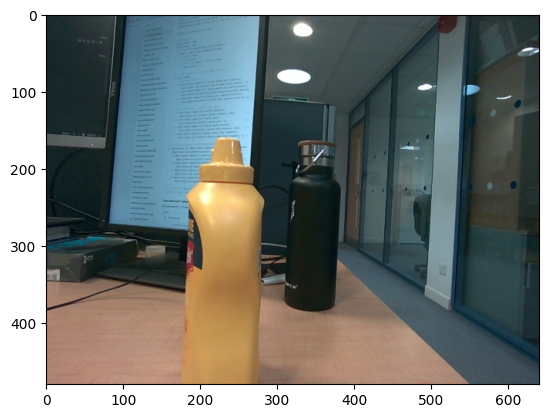

In [48]:
import matplotlib.pyplot as plt

plt.imshow(colour_frames[2])